In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import notebook

from hidden_space_visualization import add_embedding

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'

# Dataset

In [2]:
BATCH_SIZE = 1024

with np.load('D:/Datasets/mnist.npz') as mnist:
    x_train, y_train, x_test, y_test = mnist['x_train'], mnist['y_train'], mnist['x_test'], mnist['y_test']

dataloader = torch.utils.data.DataLoader([*zip(x_train, y_train)], batch_size=BATCH_SIZE, shuffle=True)

# Models

In [3]:
H_DIM = 8
LEAKY = 0.1  # LeakyReLU coefficient

In [4]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(28 * 28, 256), 
            # nn.BatchNorm1d(256),  # Makes things worse
            nn.LeakyReLU(LEAKY),
            nn.Linear(256, 256),
            # nn.BatchNorm1d(256),  # Makes things worse
            nn.LeakyReLU(LEAKY),
            nn.Linear(256, 1),
        )
        
    def forward(self, x):
        return torch.sigmoid(self.disc(x))
    
discriminator = Discriminator().to(DEVICE)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

print(summary(discriminator, (2, 28 * 28), device=DEVICE))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [2, 1]                    --
│    └─Linear: 2-1                       [2, 256]                  200,960
│    └─LeakyReLU: 2-2                    [2, 256]                  --
│    └─Linear: 2-3                       [2, 256]                  65,792
│    └─LeakyReLU: 2-4                    [2, 256]                  --
│    └─Linear: 2-5                       [2, 1]                    257
Total params: 267,009
Trainable params: 267,009
Non-trainable params: 0
Total mult-adds (M): 0.53
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 1.07
Estimated Total Size (MB): 1.08


In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(H_DIM, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(LEAKY),
            nn.Linear(256, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(LEAKY),
            nn.Linear(256, 28 * 28),
        )
        
    def forward(self, x):
        return torch.tanh(self.gen(x)).view(-1, 1, 28, 28)
    
generator = Generator().to(DEVICE)
optimizer_g = torch.optim.Adam(generator.parameters(), lr=1e-4)

print(summary(generator, (2, H_DIM), device=DEVICE))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                --                        --
├─Sequential: 1-1                        [2, 784]                  --
│    └─Linear: 2-1                       [2, 256]                  2,048
│    └─BatchNorm1d: 2-2                  [2, 256]                  512
│    └─LeakyReLU: 2-3                    [2, 256]                  --
│    └─Linear: 2-4                       [2, 256]                  65,536
│    └─BatchNorm1d: 2-5                  [2, 256]                  512
│    └─LeakyReLU: 2-6                    [2, 256]                  --
│    └─Linear: 2-7                       [2, 784]                  201,488
Total params: 270,096
Trainable params: 270,096
Non-trainable params: 0
Total mult-adds (M): 0.54
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.08
Estimated Total Size (MB): 1.11


In [11]:
# GET DISCRIMINATOR LR

for pg in optimizer_d.param_groups:
    print(pg['lr'])

0.0005


In [13]:
# CHANGE DISCRIMINATOR LR

for pg in optimizer_d.param_groups:
    pg['lr'] = 5e-5

In [12]:
# GET GENERATOR LR

for pg in optimizer_g.param_groups:
    print(pg['lr'])

0.0003


In [14]:
# CHANGE GENERATOR LR

for pg in optimizer_g.param_groups:
    pg['lr'] = 3e-5

# Tensorboard

In [6]:
tb = SummaryWriter('runs/FC-GAN_MNIST_8/fake')

In [81]:
tb.close()

# Training

In [9]:
step = 1

In [10]:
FIXED_NOISE = torch.randn(24, H_DIM).to(DEVICE)  # hidden points for samples

In [ ]:
EPOCHS = 1000
MONITORING_INTERVAL = 2  # epoch interval to save result images eamples
SAVE_INTERVAL = 10  # save model weights and optimizer state every SAVE_INTERVAL epoch; use 0 for no save

for epoch in range(EPOCHS):
    pbar = notebook.tqdm(dataloader)
    pbar.color='red'
    for batch_idx, (x_real, lbl) in enumerate(pbar):
        pbar.set_description(f'EPOCHE={epoch + 1}')

        x_real = x_real / 255.
        x_real = x_real * 2 - 1
        x_real = x_real.view(-1, 28 * 28).to(DEVICE, dtype=torch.float)
        
        batch_size = x_real.shape[0]
        noise = torch.randn((batch_size, H_DIM)).to(DEVICE)
        
        ## DISCRIMINATOR
        discriminator.train()
        generator.eval()
        fake = generator(noise).view(-1, 28 * 28)

        discriminator_real = discriminator(x_real).view(-1)
        discriminator_fake = discriminator(fake).view(-1)
        loss_d_real = nn.BCELoss()(discriminator_real, torch.ones_like(discriminator_real))
        loss_d_fake = nn.BCELoss()(discriminator_fake, torch.zeros_like(discriminator_fake))
        loss_d = (loss_d_real + loss_d_fake) / 2
        discriminator.zero_grad()
        loss_d.backward()
        optimizer_d.step()
        
        accuracy_d = accuracy_score(torch.cat([discriminator_real, discriminator_fake], dim=0).detach().round().to('cpu'), 
                                    torch.cat([torch.ones_like(discriminator_real), torch.zeros_like(discriminator_fake)], dim=0).detach().round().to('cpu'))
        
        ## GENERATOR
        discriminator.eval()
        generator.train()
        fake = generator(noise).view(-1, 28 * 28)
        
        output = discriminator(fake).view(-1)
        loss_g = nn.BCELoss()(output, torch.ones_like(output))
        generator.zero_grad()
        loss_g.backward()
        optimizer_g.step()
        
        ## MONITORING
        pbar.set_postfix({'accuracy_d->': accuracy_d, 'loss_d->': float(loss_d), 'loss_g->': float(loss_g), 'step->': str(step)})
        
        step += 1


    ## SAVE IMAGES EXAMPLES
    if MONITORING_INTERVAL and not epoch % MONITORING_INTERVAL:
        generator.eval()
        with torch.no_grad():
            tb.add_images('FC-GAN FAKE', ((generator(FIXED_NOISE) + 1) / 2).detach(), global_step=step - 1)

    ## SAVE MODEL WEIGHTS AND OPTIMIZER STATE
    if SAVE_INTERVAL and not epoch % SAVE_INTERVAL:
        torch.save({
            'discriminator': discriminator.state_dict(), 
            'optimizer_d': optimizer_d.state_dict(),
            'generator': generator.state_dict(), 
            'optimizer_g': optimizer_g.state_dict(),
            }, f'checkpoints/weights_FC-GAN-MNIST-hdim{H_DIM}-step{step - 1}.pth')

In [6]:
## LOAD

params = torch.load('checkpoints/_weights_FC-GAN-MNIST-hdim64.pth', map_location=DEVICE)

discriminator.load_state_dict(params['discriminator'])
generator.load_state_dict(params['generator'])
optimizer_d.load_state_dict(params['optimizer_d'])
optimizer_g.load_state_dict(params['optimizer_g'])

# Let's Play

In [16]:
generator.eval();

In [ ]:
## Plot examples

fig, axs = plt.subplots(3, 8, figsize=(8, 3))
with torch.no_grad():
    for ax, fake_i in zip(axs.ravel(), (generator(FIXED_NOISE).detach().to('cpu') + 1) / 2):
        ax.imshow(fake_i.view(28, 28, -1), cmap='gray')
        ax.axis('off')
plt.tight_layout()

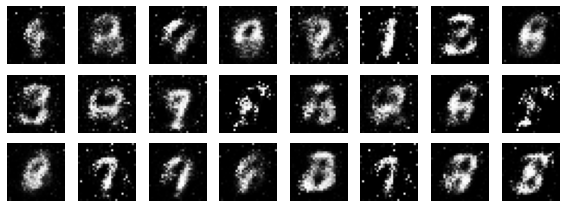

In [15]:
## H_DIM = 8

fig, axs = plt.subplots(3, 8, figsize=(8, 3))
with torch.no_grad():
    for ax, fake_i in zip(axs.ravel(), (generator(FIXED_NOISE).detach().to('cpu') + 1) / 2):
        ax.imshow(fake_i.view(28, 28, -1), cmap='gray')
        ax.axis('off')
plt.tight_layout()

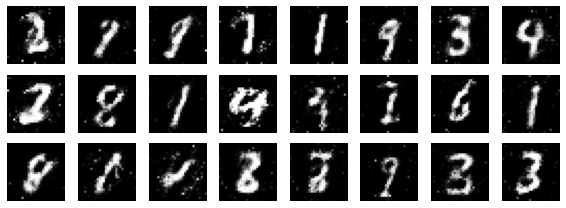

In [20]:
## H_DIM = 64

fig, axs = plt.subplots(3, 8, figsize=(8, 3))
with torch.no_grad():
    for ax, fake_i in zip(axs.ravel(), (generator(FIXED_NOISE).detach().to('cpu') + 1) / 2):
        ax.imshow(fake_i.view(28, 28, -1), cmap='gray')
        ax.axis('off')
plt.tight_layout()

# Hidden space visualization

In [ ]:
add_embedding(generator, summary_writer=tb, h_dim=H_DIM, tag='FC-GAN_64D', device=DEVICE)